In [1]:
# pip install tailer
# pip install apscheduler

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow
import tailer as tl
import pandas as pd
import io
import sys
import os

/home/ishadi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#     from math import sqrt
#     from numpy import concatenate
#     from matplotlib import pyplot
#     from pandas import read_csv
#     from pandas import DataFrame
#     from pandas import concat
#     from sklearn.preprocessing import MinMaxScaler
#     from sklearn.preprocessing import LabelEncoder
#     from sklearn.metrics import mean_squared_error
#     from keras.models import Sequential
#     from keras.layers import Dense
#     from keras.layers import LSTM
#     import tensorflow
#     import tailer as tl
#     import pandas as pd
#     import io

In [3]:
def runModel():
    # convert series to supervised learning
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
       n_vars = 1 if type(data) is list else data.shape[1]
       df = DataFrame(data)
       cols, names = list(), list()
       # input sequence (t-n, ... t-1)
       for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
       # forecast sequence (t, t+1, ... t+n)
       for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
             names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
          else:
             names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
       # put it all together
       agg = concat(cols, axis=1)
       agg.columns = names

       # drop rows with NaN values
       if dropnan:
         agg.dropna(inplace=True)
       return agg
    
    # load dataset
    dataset = read_csv('Output.txt',index_col=0)  #, nrows=5
    dataset = dataset[-100:]
    values = dataset.values
    
    # ensure all data is float
    values = values.astype('float32')
    
    # normalize features
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled = scaler.fit_transform(values)
    
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    print(reframed.head(5))
    
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
    
    # print 1st 5 rows of transformed dataset, can observe 2 input variables (input series) and the 1 output variable (NZX50 index for next month).
    print(reframed.head())
    
    # split into train and test sets
    values = reframed.values
    n_train_hours = 80

    # data rows up to 120
    train = values[:n_train_hours, :]
    
    # data rows after 120
    test = values[n_train_hours:, :]
    
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    print('Train data')
    print(train_X)
    
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    print('Train shape')
    print(train_X.shape)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # prints the shape of the train and test input and output sets with about 2000 of data for training and about 671 for testing.
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    # define LSTM design network with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 3 features. 
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    
    #use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent
    model.compile(loss='mse', optimizer='rmsprop')
    
    # fit network. The model will be fit for 262 training epochs with a batch size of 300 and  keep track of both the training and test loss during training by setting the validation_data argument in the fit() function.
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle= False)
    
    # At the end of the run both the training and test loss are plotted.
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # After the model is fit, model can be used to forecast for the entire test dataset.
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    
    #Print predicted values 
#     print('yhat x')
    print(inv_yhat)
    
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    
#     aa=[x for x in range(10)]
#     pyplot.plot(aa, inv_y[:10], marker='.', label="actual")
#     pyplot.plot(aa, inv_yhat[:10], 'r', label="prediction")
#     pyplot.ylabel('foreign currency rate', size=15)
#     pyplot.xlabel('Time step', size=15)
#     pyplot.legend(fontsize=15)
#     pyplot.show()
    

In [4]:
from apscheduler.schedulers.blocking import BlockingScheduler as scheduler

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.000000   0.000000   0.000000        0.0  0.014740  0.014740  0.015884   
2   0.014740   0.014740   0.015884        0.0  0.113495  0.113495  0.113495   
3   0.113495   0.113495   0.113495        0.0  0.099884  0.099884  0.101013   
4   0.099884   0.099884   0.101013        0.0  0.094193  0.094193  0.094193   
5   0.094193   0.094193   0.094193        0.0  0.121445  0.121445  0.121445   

   var4(t)  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
5      0.0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.000000   0.000000   0.000000        0.0  0.014740
2   0.014740   0.014740   0.015884        0.0  0.113495
3   0.113495   0.113495   0.113495        0.0  0.099884
4   0.099884   0.099884   0.101013        0.0  0.094193
5   0.094193   0.094193   0.094193        0.0  0.121445
Train data
[[0.         0.         0.         0.        ]
 [0.01473999 0.01473999 0.0158844  0.        ]
 [0.11

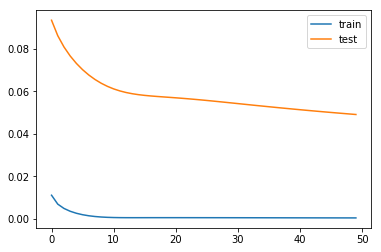

[1.139408  1.139408  1.1393948 1.1394012 1.1394111 1.1394325 1.1394292
 1.1394128 1.1394292 1.1394374 1.1394374 1.1394292 1.1394325 1.1394374
 1.1394374 1.139403  1.1393766 1.1393441 1.1434397]
Test RMSE: 0.002
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.179810   0.179810   0.179810        0.0  0.057556  0.057556  0.057556   
2   0.057556   0.057556   0.057556        0.0  0.000000  0.000000  0.000000   
3   0.000000   0.000000   0.000000        0.0  0.093445  0.093445  0.100647   
4   0.093445   0.093445   0.100647        0.0  0.719360  0.719360  0.719360   
5   0.719360   0.719360   0.719360        0.0  0.633118  0.633118  0.640320   

   var4(t)  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
5      0.0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.179810   0.179810   0.179810        0.0  0.057556
2   0.057556   0.057556   0.057556        0.0  0.000000
3   0.000000   0.000000   0.000000        0.0  0.093445
4   0.093445

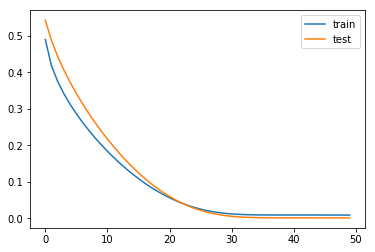

[1.1393726 1.1393696 1.1393994 1.1393994 1.1393801 1.13939   1.1394048
 1.1394365 1.139432  1.1394068 1.139432  1.1394439 1.1394439 1.139432
 1.1394365 1.1394439 1.1394439 1.1393919 1.1393528]
Test RMSE: 0.000
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.179810   0.179810   0.179810        0.0  0.057556  0.057556  0.057556   
2   0.057556   0.057556   0.057556        0.0  0.000000  0.000000  0.000000   
3   0.000000   0.000000   0.000000        0.0  0.093445  0.093445  0.100647   
4   0.093445   0.093445   0.100647        0.0  0.719360  0.719360  0.719360   
5   0.719360   0.719360   0.719360        0.0  0.633118  0.633118  0.640320   

   var4(t)  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
5      0.0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.179810   0.179810   0.179810        0.0  0.057556
2   0.057556   0.057556   0.057556        0.0  0.000000
3   0.000000   0.000000   0.000000        0.0  0.093445
4   0.093445 

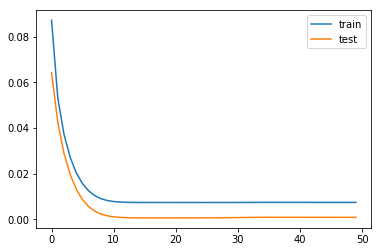

[1.139358  1.1393552 1.1393895 1.1393895 1.1393666 1.139378  1.1393951
 1.1394324 1.1394266 1.1393981 1.1394266 1.139441  1.139441  1.1394266
 1.1394324 1.139441  1.139441  1.1393809 1.1393352]
Test RMSE: 0.000
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.179810   0.179810   0.179810        0.0  0.057556  0.057556  0.057556   
2   0.057556   0.057556   0.057556        0.0  0.000000  0.000000  0.000000   
3   0.000000   0.000000   0.000000        0.0  0.093445  0.093445  0.100647   
4   0.093445   0.093445   0.100647        0.0  0.719360  0.719360  0.719360   
5   0.719360   0.719360   0.719360        0.0  0.633118  0.633118  0.640320   

   var4(t)  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
5      0.0  
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.179810   0.179810   0.179810        0.0  0.057556
2   0.057556   0.057556   0.057556        0.0  0.000000
3   0.000000   0.000000   0.000000        0.0  0.093445
4   0.093445

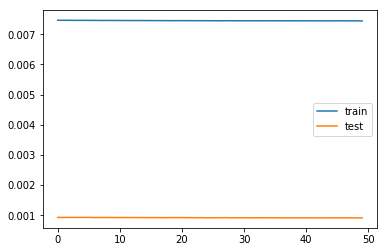

[1.1393584 1.1393557 1.1393901 1.1393901 1.139367  1.1393784 1.1393957
 1.1394331 1.1394274 1.1393987 1.1394274 1.1394418 1.1394418 1.1394274
 1.1394331 1.1394418 1.1394418 1.1393814 1.1393354]
Test RMSE: 0.000


KeyboardInterrupt: 

In [5]:
sch = scheduler()
sch.add_job(runModel, 'interval', seconds=80)
sch.start()